In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Cardiac\ Project/Registration_phase/based\ on\ doc1

/content/drive/MyDrive/Cardiac Project/Registration_phase/based on doc1


# Imports

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms

import random
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import skimage.io as io
from skimage.transform import resize
#import multiprocessing as mp #


#import gc #
#from matplotlib.lines import Line2D #
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
use_gpu = torch.cuda.is_available()

# Dataset Creation

In [5]:
path = './phase_4_CycleMorph/dataset/'

In [6]:
def read_dataset(path):
    cine_dataset = []
    lge_dataset = []
    for filename in tqdm(glob.iglob(path + '**/*.png' , recursive = True)):
        class_type = filename.split('/')[3]
        image_name = filename.split('/')[4]
        image = cv2.imread(filename ,  cv2.IMREAD_GRAYSCALE)
        image = transforms.ToTensor()(image)
        if class_type == 'cine_images':
            cine_dataset.append((image , image_name))
        if class_type == 'lge_images':
            lge_dataset.append((image , image_name))

    cine_dataset.sort(key = lambda x: x[1]) 
    lge_dataset.sort(key = lambda x: x[1]) 
 
    dataset = []
    for i in range(len(cine_dataset)):
        cine_image = cine_dataset[i][0]
        lge_image = lge_dataset[i][0]
        dataset.append((cine_image , lge_image))

    return dataset

In [7]:
dataset = read_dataset(path)

598it [03:38,  2.73it/s]


In [8]:
len(dataset)

299

In [9]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.3, random_state=42)

In [10]:
train_loader = data.DataLoader(train_dataset ,
                               batch_size = 20,
                               shuffle = True,
                               num_workers =  6,
                               worker_init_fn =  np.random.seed(42))  
test_loader = data.DataLoader(test_dataset ,
                               batch_size = 20,
                               shuffle = False,
                               num_workers =  6,
                               worker_init_fn =  np.random.seed(42))     

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model Definition

In [11]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [12]:
class SpatialTransformation(nn.Module):
    def __init__(self, use_gpu=False):
        self.use_gpu = use_gpu
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        if self.use_gpu==True:
            x_t = x_t.cuda()
            y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        if self.use_gpu:
            x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))


    def interpolate(self, im, x, y):
        im = im.permute(0,2,3,1)
        im = F.pad(im, (0,0,1,1,1,1,0,0))
        
        batch_size, height, width, channels = im.shape
        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        # and finally calculate interpolated values
        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output.permute(0,3,1,2)

    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


In [13]:
class VoxelMorph2d(nn.Module):
    def __init__(self, in_channels, use_gpu=False):
        super(VoxelMorph2d, self).__init__()
        self.unet = UNet(in_channels, 2)
        self.spatial_transform = SpatialTransformation(use_gpu)
        if use_gpu:
            self.unet = self.unet.cuda()
            self.spatial_transform = self.spatial_transform.cuda()

    def forward(self, moving_image, fixed_image):
        
        x = torch.cat([moving_image, fixed_image], dim=1)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image , deformation_matrix

In [14]:
def cross_correlation_loss(I, J, n = 9):

    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I)
    J2 = torch.mul(J, J)
    IJ = torch.mul(I, J)
    sum_filter = torch.ones((1, channels, n, n))
    if use_gpu:
        sum_filter = sum_filter.cuda()
    I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
    J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
    win_size = n**2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
    cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
    return torch.mean(cc)

def smooothing_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def cycle_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0


def CycleMorphLoss(Xs , Ys , Xs_hat, Ys_hat, Xs_tilda, Ys_tilda ,Xs_ident, Ys_ident):
    
    LAMBDA = 0.1
    ALPHA = 0.4
    BETA = 0.1

    # L_regist_Gx
    L_sim_Gx = cross_correlation_loss(Ys_hat, Ys)
    L_smooth_Gx = smooothing_loss(Ys_hat)
    L_regist_Gx = -L_sim_Gx + LAMBDA * L_smooth_Gx

    # L_regist_Gy
    L_sim_Gy = cross_correlation_loss(Xs_hat, Xs)
    L_smooth_Gy = smooothing_loss(Xs_hat)
    L_regist_Gy = -L_sim_Gy + LAMBDA * L_smooth_Gy

    # L_Cycle
    L1 = nn.L1Loss()
    L_Cycle = L1(Xs, Xs_tilda) + L1(Ys, Ys_tilda)

    # L_indentity
    L_identity = - cross_correlation_loss(Ys_ident , Ys) - cross_correlation_loss(Xs_ident , Xs)

    loss = L_regist_Gx + L_regist_Gy + ALPHA*L_Cycle + BETA*L_identity
    return loss

def VoxelMorphLoss (y, ytrue):
    LAMBDA = 0.01
    cc = cross_correlation_loss(y, ytrue)
    sm = smooothing_loss(y)
    loss = -1.0 * cc + LAMBDA * sm
    return loss

def dice_score(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    #print("Dice score", dice)
    return dice

In [15]:
def train_CycleMorph(Gx, Gy , train_loader , optimizerGx, optimizerGy , epochs):
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_dice = 0
        for Xs , Ys in train_loader:
            optimizerGx.zero_grad()
            optimizerGy.zero_grad()

            Xs = Xs.to(device)
            Ys = Ys.to(device)

            Ys_hat , _ = Gx(Xs, Ys)
            Xs_hat , _ = Gy(Ys, Xs)

            Ys_tilda , _ = Gx(Xs_hat, Ys_hat)
            Xs_tilda , _ = Gy(Ys_hat, Xs_hat)

            Ys_ident , _ = Gx(Ys, Ys)
            Xs_ident , _  = Gy(Xs, Xs)


            train_loss = CycleMorphLoss(Xs , Ys , Xs_hat, Ys_hat, Xs_tilda, Ys_tilda ,Xs_ident, Ys_ident)

            train_loss.backward()

            optimizerGx.step()
            optimizerGy.step()

            epoch_loss += train_loss.item()
        print(epoch , epoch_loss/len(train_loader.dataset) )

In [16]:
def train_VoxelMorph(model , train_loader ,epochs):
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_dice = 0
        for fixed_batch , moving_batch in train_loader:
            optimizer.zero_grad()
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images , _ = model(moving_batch , fixed_batch)
            train_loss = VoxelMorphLoss(registered_images, fixed_batch)
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
        print(epoch , epoch_loss/len(train_dataset) )

In [17]:
################# Voxel Morph #####################
model = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)
optimizer= optim.Adam(model.parameters(), lr=1e-3)

In [18]:
################# Cycle Morph #####################
Gx = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)
Gy = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)

optimizerGx = optim.Adam(Gx.parameters(), lr=1e-3)
optimizerGy = optim.Adam(Gy.parameters(), lr=1e-3)

In [19]:
train_VoxelMorph(model , train_loader , epochs = 30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 -0.01415427064781554
1 -0.01658619319993343
2 -0.018070556615528307
3 -0.019478338186820727
4 -0.020686516636296323
5 -0.02160356988747154
6 -0.02237077962838862
7 -0.022835947822725945
8 -0.02343919944535032
9 -0.024114926893745312
10 -0.024306953381123157
11 -0.02473426991672607
12 -0.02524098283366153
13 -0.025814834536547867
14 -0.025938515172620708
15 -0.02640779038365378
16 -0.026670428554407148
17 -0.026937181869762367
18 -0.0274370569361454
19 -0.02757344947477277
20 -0.02773063405278767
21 -0.02802280646762209
22 -0.028253379335814115
23 -0.028650655986019298
24 -0.028752036927419417
25 -0.02896517258511776
26 -0.029104141527385802
27 -0.02939845158152603
28 -0.02970302646810358
29 -0.029840055835304077


In [ ]:
train_VoxelMorph(model , train_loader , epochs = 30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 -0.014393651029139615
1 -0.017013828435012597
2 -0.01851063196738941
3 -0.0193860470963437
4 -0.020231890906557512
5 -0.021054000232778668
6 -0.02194263233522479
7 -0.022656435173664367
8 -0.023312390135806143
9 -0.02389169110065442
10 -0.024168346487163928
11 -0.02463654753123744
12 -0.025110237621234363
13 -0.02553703953204543
14 -0.025945149968115335
15 -0.026327313133404015
16 -0.026687310500578446
17 -0.026825116296704307
18 -0.027263830723374655
19 -0.027402698138113798
20 -0.027833852613941903
21 -0.028238861184371144
22 -0.02798526766197533
23 -0.028350335844395835
24 -0.028845017606561833
25 -0.02910250853123277
26 -0.029512123913285834
27 -0.029597728446339875
28 -0.02969315662338403
29 -0.030145544754831416


In [ ]:
train_CycleMorph(Gx, Gy , train_loader , optimizerGx, optimizerGy , epochs = 30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 -0.03517673032705864
1 -0.039939228142277475
2 -0.04244611052234777
3 -0.04441361478641273
4 -0.04578744965877259
5 -0.04720031188435532
6 -0.04841076272526426
7 -0.04938082090405186
8 -0.05082368052176882
9 -0.051525157889681
10 -0.05242470405888899
11 -0.05350521363710102
12 -0.05417993479368219
13 -0.055449434729854453
14 -0.05591640717675241
15 -0.05673933913262837
16 -0.05696864390487306
17 -0.057306533510034736
18 -0.057742709178103216
19 -0.05910092620758349
20 -0.059085870473578786
21 -0.059919988139394365
22 -0.06068232127924285
23 -0.06143406247408196
24 -0.06141258483868467
25 -0.06181306816174083
26 -0.062304508743103615
27 -0.06273018686394942
28 -0.06333975814746327
29 -0.06401854154595918


In [ ]:
def test_CyleMorph(Gx, Gy , test_loader):
        all_loss = 0
        for Xs , Ys in test_loader:

            Xs = Xs.to(device)
            Ys = Ys.to(device)

            Ys_hat , _ = Gx(Xs, Ys)
            Xs_hat , _ = Gy(Ys, Xs)

            Ys_tilda , _ = Gx(Xs_hat, Ys_hat)
            Xs_tilda , _ = Gy(Ys_hat, Xs_hat)

            Ys_ident , _ = Gx(Ys, Ys)
            Xs_ident , _ = Gy(Xs, Xs)


            test_loss = CycleMorphLoss(Xs , Ys , Xs_hat, Ys_hat, Xs_tilda, Ys_tilda ,Xs_ident, Ys_ident)


            all_loss += test_loss.item()
        print(all_loss/len(test_dataset) )
        return Xs , Ys ,Ys_tilda

In [20]:
def test_VoxelMorph(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        for fixed_batch , moving_batch in test_loader:
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images , _ = model(moving_batch , fixed_batch)
            test_loss = VoxelMorphLoss(registered_images, fixed_batch)
            all_loss += test_loss.item()
        print(all_loss/len(test_dataset)) 
        return fixed_batch, moving_batch , registered_images     

In [ ]:
fixed_batch_C , moving_batch_C , registered_images_C = test_CyleMorph(Gx, Gy , test_loader)

In [22]:
fixed_batch_V , moving_batch_V , registered_images_V = test_VoxelMorph(model , test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.029752884970770943


Text(0.5, 1.0, 'VoxelMorph')

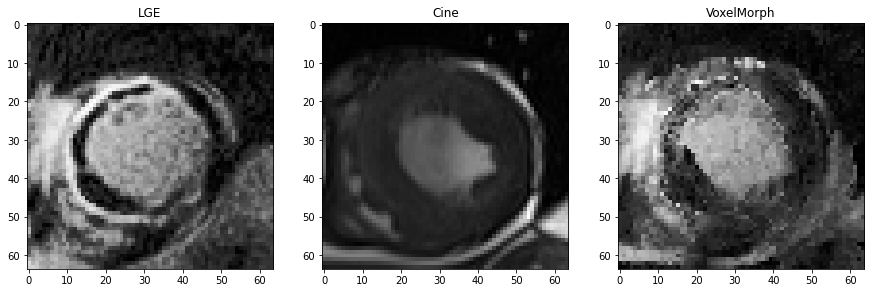

In [30]:
sample = 2
fig , (ax1 , ax2 , ax3) = plt.subplots(1,3,figsize = (15,10))
ax1.imshow(moving_batch_V[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.imshow(fixed_batch_V[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.imshow(registered_images_V[sample].squeeze(0).cpu().detach().numpy() , cmap = 'gray')
ax1.set_title("LGE")
ax2.set_title("Cine")
ax3.set_title("VoxelMorph")


Text(0.5, 1.0, 'CycleMorph')

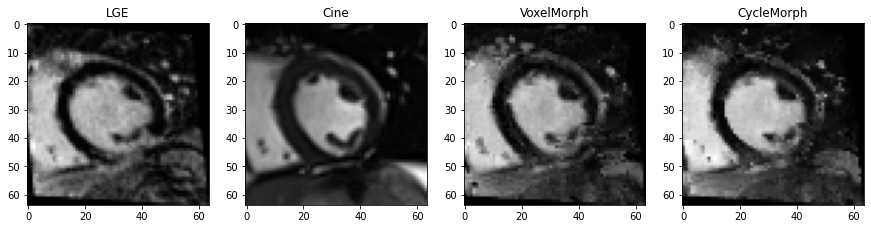

In [ ]:
sample = 3
fig , (ax1 , ax2 , ax3 , ax4) = plt.subplots(1,4,figsize = (15,10))
ax1.imshow(moving_batch_V[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.imshow(fixed_batch_V[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.imshow(registered_images_V[sample].squeeze(0).cpu().detach().numpy() , cmap = 'gray')
ax4.imshow(registered_images_C[sample].squeeze(0).cpu().detach().numpy() , cmap = 'gray')
ax1.set_title("LGE")
ax2.set_title("Cine")
ax3.set_title("VoxelMorph")
ax4.set_title("CycleMorph")

In [ ]:
cine = cv2.imread("./phase_3_segmentation/423841/cine.png" , cv2.IMREAD_GRAYSCALE)
main_lge = cv2.imread("./phase_3_segmentation/423841/main_lge.png", cv2.IMREAD_GRAYSCALE)
rigid_c_lge = cv2.imread("./phase_3_segmentation/423841/rigid_c_lge.png", cv2.IMREAD_GRAYSCALE)
rigid_lge = cv2.imread("./phase_3_segmentation/423841/rigid_lge.png", cv2.IMREAD_GRAYSCALE)


fixed_batch = transforms.ToTensor()(cine)
moving_batch = transforms.ToTensor()(rigid_lge)
moving_c = transforms.ToTensor()(rigid_c_lge)
fixed_batch = fixed_batch.unsqueeze(0)
moving_batch = moving_batch.unsqueeze(0)
moving_c = moving_c.unsqueeze(0)

In [ ]:
ST = SpatialTransformation(use_gpu)

In [ ]:
fixed_batch = fixed_batch.to(device)
moving_batch = moving_batch.to(device)
moving_c = moving_c.to(device)

registered_images_V1 , Tv= model(moving_batch , fixed_batch)

registered_images_V2 = ST(moving_c, Tv)

Ys_hat , Tx = Gx(fixed_batch, moving_batch)
Xs_hat , Ty = Gy(moving_batch, fixed_batch)

registered_images_C , Tx = Gx(Xs_hat, Ys_hat)
registered_images_C = ST(moving_c, Tx)

Xs_tilda , Ty = Gy(Ys_hat, Xs_hat)

Text(0.5, 1.0, 'CycleMorph')

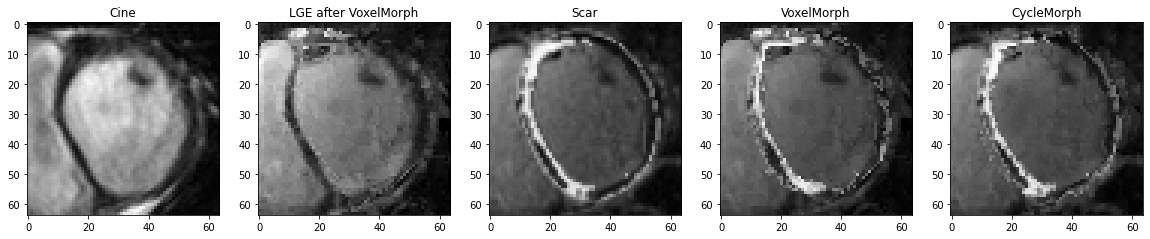

In [ ]:

fig , (ax1 , ax2 , ax3 , ax4 , ax5) = plt.subplots(1,5,figsize = (20,10))
ax2.imshow(registered_images_V1.squeeze(0).squeeze(0).cpu().detach().numpy()  , cmap = 'gray')
ax1.imshow(fixed_batch.squeeze(0).squeeze(0).cpu() , cmap = 'gray')
ax3.imshow(moving_c.squeeze(0).squeeze(0).cpu() , cmap = 'gray')
ax4.imshow(registered_images_V1.squeeze(0).squeeze(0).cpu().detach().numpy()  , cmap = 'gray')
ax4.imshow(registered_images_V2.squeeze(0).squeeze(0).cpu().detach().numpy()  , cmap = 'gray')
ax5.imshow(registered_images_C.squeeze(0).squeeze(0).cpu().detach().numpy() , cmap = 'gray')

ax1.set_title("Cine")
ax2.set_title("LGE after VoxelMorph")
ax3.set_title("Scar")
ax4.set_title("VoxelMorph")
ax5.set_title("CycleMorph")